<a href="https://colab.research.google.com/github/LanxyL/Capstone3---Recommendation-System/blob/main/Notebook/Recommendation_System_on_Amazon_home_kitchen_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_absolute_error

In [3]:
#Read Kitchen&Dining Dataset from last notebook
KitchenDining = pd.read_csv('drive/My Drive/Recommendation_System/KitchenDining80000.csv')

In [4]:
# transform the ratings frame into a ratings matrix
ratings_mtx_df = KitchenDining.pivot_table(values='overall',
                                           index='reviewerID',
                                           columns='asin')
ratings_mtx_df.head(3)

asin,0912696591,B00000JGRP,B00000JGRQ,B00000JGRT,B00002N602,B00004OCIP,B00004OCIQ,B00004OCIU,B00004OCIX,B00004OCIZ,B00004OCJ6,B00004OCJ9,B00004OCJJ,B00004OCJK,B00004OCJN,B00004OCJO,B00004OCJQ,B00004OCJW,B00004OCK0,B00004OCK3,B00004OCKO,B00004OCKR,B00004OCKT,B00004OCL2,B00004OCL8,B00004OCL9,B00004OCLA,B00004OCLK,B00004OCLW,B00004OCM4,B00004OCMB,B00004OCMM,B00004OCMS,B00004OCMX,B00004OCMY,B00004OCNE,B00004OCNJ,B00004OCNK,B00004OCNL,B00004OCNQ,...,B00JW02L9W,B00JWXSPAS,B00JWY1PPE,B00JWYX7YQ,B00JWZCE08,B00JZKZPMO,B00JZL11V2,B00JZXYG9O,B00K11U0Y4,B00K4S1L1K,B00K4V4EWA,B00K6BCV7S,B00K7ILPYU,B00K7P0D9G,B00K8LHA3G,B00KAF5DLQ,B00KAJ3OY0,B00KAK443Y,B00KB7KNRM,B00KBQ1OHQ,B00KBUGQJS,B00KCFDB4U,B00KD83BMS,B00KDV5RZY,B00KFS40N0,B00KI2RQHU,B00KIVD1PC,B00KKYSBUW,B00KM9W2PU,B00KNPVL8W,B00KQCJ0CG,B00KQXDIG4,B00KSRQN0Q,B00KSRSZC0,B00KSRV3UQ,B00KSRXUC0,B00KW1ZDCM,B00KWKQ2MS,B00L8FQZ3M,B00LB18EKK
reviewerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A00473363TJ8YSZ3YAGG9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A00593903MCE5GXTAGGNL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A037357115LCU92V2R0YR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(KitchenDining, test_size=0.2)

In [6]:
print(train.shape)
print(test.shape)
print(KitchenDining.shape)

(65558, 24)
(16390, 24)
(81948, 24)


In [7]:
# transform the train ratings frame into a ratings matrix
train_sparse = train.pivot_table(values='overall',
                                 index='reviewerID',
                                 columns='asin')
train_sparse.head(3)

asin,0912696591,B00000JGRP,B00000JGRQ,B00000JGRT,B00002N602,B00004OCIP,B00004OCIQ,B00004OCIU,B00004OCIX,B00004OCIZ,B00004OCJ6,B00004OCJ9,B00004OCJJ,B00004OCJK,B00004OCJN,B00004OCJO,B00004OCJQ,B00004OCJW,B00004OCK0,B00004OCK3,B00004OCKO,B00004OCKR,B00004OCKT,B00004OCL2,B00004OCL8,B00004OCL9,B00004OCLA,B00004OCLK,B00004OCLW,B00004OCM4,B00004OCMB,B00004OCMM,B00004OCMS,B00004OCMX,B00004OCMY,B00004OCNE,B00004OCNJ,B00004OCNK,B00004OCNL,B00004OCNQ,...,B00JW02L9W,B00JWXSPAS,B00JWY1PPE,B00JWYX7YQ,B00JWZCE08,B00JZKZPMO,B00JZL11V2,B00JZXYG9O,B00K11U0Y4,B00K4S1L1K,B00K4V4EWA,B00K6BCV7S,B00K7ILPYU,B00K7P0D9G,B00K8LHA3G,B00KAF5DLQ,B00KAJ3OY0,B00KAK443Y,B00KB7KNRM,B00KBQ1OHQ,B00KBUGQJS,B00KCFDB4U,B00KD83BMS,B00KDV5RZY,B00KFS40N0,B00KI2RQHU,B00KIVD1PC,B00KKYSBUW,B00KM9W2PU,B00KNPVL8W,B00KQCJ0CG,B00KQXDIG4,B00KSRQN0Q,B00KSRSZC0,B00KSRV3UQ,B00KSRXUC0,B00KW1ZDCM,B00KWKQ2MS,B00L8FQZ3M,B00LB18EKK
reviewerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A00473363TJ8YSZ3YAGG9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A00593903MCE5GXTAGGNL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A037357115LCU92V2R0YR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# transform the test ratings frame into a ratings matrix
test_sparse = test.pivot_table(values='overall',
                               index='reviewerID',
                               columns='asin')
test_sparse.head(3)

asin,0912696591,B00000JGRP,B00000JGRQ,B00000JGRT,B00002N602,B00004OCIP,B00004OCIQ,B00004OCIU,B00004OCIX,B00004OCIZ,B00004OCJ6,B00004OCJ9,B00004OCJJ,B00004OCJK,B00004OCJN,B00004OCJO,B00004OCJQ,B00004OCJW,B00004OCK0,B00004OCK3,B00004OCKO,B00004OCKR,B00004OCKT,B00004OCL2,B00004OCL8,B00004OCL9,B00004OCLA,B00004OCLK,B00004OCLW,B00004OCM4,B00004OCMB,B00004OCMM,B00004OCMS,B00004OCMX,B00004OCMY,B00004OCNE,B00004OCNJ,B00004OCNK,B00004OCNL,B00004OCNQ,...,B00JS70WFY,B00JW02L9W,B00JWXSPAS,B00JWY1PPE,B00JWYX7YQ,B00JWZCE08,B00JZKZPMO,B00JZL11V2,B00JZXYG9O,B00K11U0Y4,B00K4S1L1K,B00K4V4EWA,B00K6BCV7S,B00K7ILPYU,B00K7P0D9G,B00K8LHA3G,B00KAF5DLQ,B00KAJ3OY0,B00KAK443Y,B00KB7KNRM,B00KBQ1OHQ,B00KBUGQJS,B00KCFDB4U,B00KDV5RZY,B00KFS40N0,B00KI2RQHU,B00KIVD1PC,B00KKYSBUW,B00KM9W2PU,B00KNPVL8W,B00KQCJ0CG,B00KQXDIG4,B00KSRQN0Q,B00KSRSZC0,B00KSRV3UQ,B00KSRXUC0,B00KW1ZDCM,B00KWKQ2MS,B00L8FQZ3M,B00LB18EKK
reviewerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A00593903MCE5GXTAGGNL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A037357115LCU92V2R0YR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A100FQFUKK14IT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
#Finding Global Average of all item ratings from sampled train dataset
print("Global average of all products raview ratings in Train Sample is {}".format(np.round(train.overall.mean(), 2)))

Global average of all products raview ratings in Train Sample is 4.41


In [10]:
print("Sparsity Of Train matrix : {}% ".format((train_sparse.isna().sum().sum()/(train_sparse.shape[1]*train_sparse.shape[0])*100)))

Sparsity Of Train matrix : 99.80412298440106% 


In [11]:
print("Sparsity Of Test matrix : {}% ".format((test_sparse.isna().sum().sum()/(test_sparse.shape[1]*test_sparse.shape[0])*100)))

Sparsity Of Test matrix : 99.93176870097514% 


In [12]:
def getAverageUserRatings(df, userid):
    return df.loc[userid, :].mean()

In [13]:
def getAverageItemRatings(df, itemid):
    return df.loc[:, itemid].mean()

In [14]:
def num_users_rate(df, itemid):
  return df.loc[:, itemid].count()

In [15]:
def num_items_rate(df, userid):
  return df.loc[userid, :].count()

In [16]:
train_surprice = train[['reviewerID', 'asin', 'overall', 'price', 'year', 'month', 'reviewlength']]
train_surprice = train_surprice.dropna()
train_surprice.head()

,reviewerID,asin,overall,price,year,month,reviewlength
5510,A3RX2SPLAXUFZH,B00004UE6N,5.0,11.41,2013,1,32
10327,A1KAOMGBS8G3PU,B00006IUTQ,5.0,6.65,2013,1,27
57188,A3S0Y5GVW1CYRW,B003UDHOD0,4.0,12.99,2013,2,112
37346,A3EPHBMU07LZ50,B000SAU3OU,2.0,29.87,2014,6,151
64947,A194K60CWZ371J,B005LCT5I0,5.0,9.99,2012,9,323


In [17]:
train_surprice['user_avg'] = train_surprice['reviewerID'].apply(lambda x: getAverageUserRatings(train_sparse, x))

In [18]:
train_surprice['item_avg'] = train_surprice['asin'].apply(lambda x: getAverageItemRatings(train_sparse, x))

In [19]:
#Obtain how many users rate each item
train_surprice['num_users_rate'] = train_surprice['asin'].apply(lambda x: num_users_rate(train_sparse, x))

In [20]:
#Obtain how many items each user rated
train_surprice['num_items_rate'] = train_surprice['reviewerID'].apply(lambda x: num_items_rate(train_sparse, x))

In [21]:
train_surprice.head()

,reviewerID,asin,overall,price,year,month,reviewlength,user_avg,item_avg,num_users_rate,num_items_rate
5510,A3RX2SPLAXUFZH,B00004UE6N,5.0,11.41,2013,1,32,4.700000,4.600000,20,10
10327,A1KAOMGBS8G3PU,B00006IUTQ,5.0,6.65,2013,1,27,5.000000,4.315789,19,6
57188,A3S0Y5GVW1CYRW,B003UDHOD0,4.0,12.99,2013,2,112,4.833333,4.060000,50,18
37346,A3EPHBMU07LZ50,B000SAU3OU,2.0,29.87,2014,6,151,4.200000,3.750000,12,70
64947,A194K60CWZ371J,B005LCT5I0,5.0,9.99,2012,9,323,4.904762,4.271930,114,21


In [22]:
test_surprice = test[['reviewerID', 'asin', 'overall', 'price', 'year', 'month', 'reviewlength']]
test_surprice = test_surprice.dropna()
test_surprice['user_avg'] = test_surprice['reviewerID'].apply(lambda x: getAverageUserRatings(test_sparse, x))
test_surprice['item_avg'] = test_surprice['asin'].apply(lambda x: getAverageItemRatings(test_sparse, x))
test_surprice['num_users_rate'] = test_surprice['asin'].apply(lambda x: num_users_rate(test_sparse, x))
test_surprice['num_items_rate'] = test_surprice['reviewerID'].apply(lambda x: num_items_rate(test_sparse, x))

In [23]:
def evaluate(estimate_f):
  """ RMSE-based predictive performance evaluation with pandas. """
  ids_to_estimate = zip(test.reviewerID, test.asin) 
  estimated = np.array([estimate_f(u,i) for (u,i) in ids_to_estimate])
  real = test.overall.values
  return np.sqrt(mean_squared_error(real, estimated))

In [24]:
#Predict all reviews as 5 star and see how accurate it would be
def simple_estimate_function(user_id, item_id): return 5

In [25]:
print('RMSE for simple estimate function: %s' % evaluate(simple_estimate_function))

RMSE for simple estimate function: 1.1643211263109017


Since we already know that most of the people rate 5 on the review. Let us set this estimation function as a threshold. A better model shall have a much smaller RMSE.

In [26]:
def content_mean(user_id, item_id):
  """ Simple content-filtering based on mean ratings. """
  if user_id in train.reviewerID.to_list():
    user_condition = train.reviewerID == user_id
    return train.loc[user_condition, 'overall'].mean()
  else:
    return 5
print('RMSE for content mean estimation: %s' % evaluate(content_mean))

RMSE for content mean estimation: 1.0171562635037295


In [27]:
def collaborative_mean(user_id, item_id):
  """ Simple collaborative-filtering based on mean ratings. """
  if item_id in train.asin.to_list():
    item_condition = train.asin == item_id
    return train.loc[item_condition, 'overall'].mean()
  else:
    return 5
print('RMSE for collaborative mean estimation: %s' % evaluate(collaborative_mean))

RMSE for collaborative mean estimation: 0.9804542411301125


In [28]:
KitchenDining.head()

,Unnamed: 0,reviewerID,asin,helpful,reviewText,overall,summary,unixReviewTime,salesRank,title,description,related,price,brand,year,month,reviewlength,mainCategory,subCategory1,subCategory2,subCategory3,subCategory4,subCategory5,subCategory6#
0,315,A39RRTO760KGOY,0912696591,"[0, 0]","had no idea about decorating cakes,by this boo...",5.0,follow the instructions,2012-05-27,{'Kitchen & Dining': 9690},Wilton Decorating Cakes Book,This exciting book presents what Wilton has l...,"{'also_bought': ['B003MC22TU', 'B003MC22PY', '...",14.26,Wilton,2012,5,56,Home & Kitchen,Kitchen & Dining,Bakeware,Baking & Cookie Sheets,NaN,NaN,NaN
1,317,AZF13R8HNB59E,0912696591,"[0, 1]","excellent book, shipped on time, packaged nice...",5.0,book,2012-06-12,{'Kitchen & Dining': 9690},Wilton Decorating Cakes Book,This exciting book presents what Wilton has l...,"{'also_bought': ['B003MC22TU', 'B003MC22PY', '...",14.26,Wilton,2012,6,24,Home & Kitchen,Kitchen & Dining,Bakeware,Baking & Cookie Sheets,NaN,NaN,NaN
2,318,A1KCBA3PKLV2IT,0912696591,"[0, 0]",i loved it. don't use it much but when i had i...,5.0,great!,2012-12-26,{'Kitchen & Dining': 9690},Wilton Decorating Cakes Book,This exciting book presents what Wilton has l...,"{'also_bought': ['B003MC22TU', 'B003MC22PY', '...",14.26,Wilton,2012,12,27,Home & Kitchen,Kitchen & Dining,Bakeware,Baking & Cookie Sheets,NaN,NaN,NaN
3,321,A3JM7FVJMPJ1XD,0912696591,"[4, 4]",So I actually bought this thinking it was the ...,3.0,Good for what it's worth,2012-08-16,{'Kitchen & Dining': 9690},Wilton Decorating Cakes Book,This exciting book presents what Wilton has l...,"{'also_bought': ['B003MC22TU', 'B003MC22PY', '...",14.26,Wilton,2012,8,92,Home & Kitchen,Kitchen & Dining,Bakeware,Baking & Cookie Sheets,NaN,NaN,NaN
4,326,A1B9BZ3AJ5V1NJ,0912696591,"[0, 0]",I'm hoping that I can learn how to make gum pa...,5.0,learning,2014-05-21,{'Kitchen & Dining': 9690},Wilton Decorating Cakes Book,This exciting book presents what Wilton has l...,"{'also_bought': ['B003MC22TU', 'B003MC22PY', '...",14.26,Wilton,2014,5,24,Home & Kitchen,Kitchen & Dining,Bakeware,Baking & Cookie Sheets,NaN,NaN,NaN


In [29]:
import json
product_related = []
for i in range(KitchenDining.shape[0]):
  product_related.append([KitchenDining.asin[i],KitchenDining.related[i]])
product_related = pd.DataFrame(product_related)
product_related = product_related.rename(columns={0:'asin', 1:'related'})
product_related.dropna(inplace=True)
product_related.drop_duplicates(inplace=True)
product_related.reset_index()
product_related.head()

,asin,related
0,0912696591,"{'also_bought': ['B003MC22TU', 'B003MC22PY', '..."
41,B00000JGRP,"{'also_viewed': ['B0000645YL', 'B0000645YM', '..."
68,B00000JGRQ,"{'also_bought': ['B00004S9CJ', 'B001D9B2R2', '..."
80,B00000JGRT,"{'also_bought': ['B00004S9D3', '0894803123', '..."
152,B00002N602,"{'also_bought': ['B000ORD8GM', '0965410803', '..."


In [30]:
product_related.shape

(3320, 2)

In [31]:
relation_dict = dict()
for i in product_related.index:
  x=product_related.related[i]
  x = str(x).replace("\'", "\"")
  dictx = json.loads(x)
  relation_dict[product_related.asin[i]] = dictx


In [32]:
product_related = pd.DataFrame(relation_dict)

In [33]:
product_related

,0912696591,B00000JGRP,B00000JGRQ,B00000JGRT,B00002N602,B00004OCIP,B00004OCIQ,B00004OCIU,B00004OCIX,B00004OCIZ,B00004OCJ6,B00004OCJ9,B00004OCJJ,B00004OCJK,B00004OCJN,B00004OCJO,B00004OCJQ,B00004OCJW,B00004OCK0,B00004OCK3,B00004OCKO,B00004OCKR,B00004OCKT,B00004OCL2,B00004OCL8,B00004OCL9,B00004OCLA,B00004OCLK,B00004OCLW,B00004OCM4,B00004OCMB,B00004OCMM,B00004OCMS,B00004OCMX,B00004OCMY,B00004OCNE,B00004OCNJ,B00004OCNK,B00004OCNL,B00004OCNQ,...,B00JW02L9W,B00JWXSPAS,B00JWY1PPE,B00JWYX7YQ,B00JWZCE08,B00JZKZPMO,B00JZL11V2,B00JZXYG9O,B00K11U0Y4,B00K4S1L1K,B00K4V4EWA,B00K6BCV7S,B00K7ILPYU,B00K7P0D9G,B00K8LHA3G,B00KAF5DLQ,B00KAJ3OY0,B00KAK443Y,B00KB7KNRM,B00KBQ1OHQ,B00KBUGQJS,B00KCFDB4U,B00KD83BMS,B00KDV5RZY,B00KFS40N0,B00KI2RQHU,B00KIVD1PC,B00KKYSBUW,B00KM9W2PU,B00KNPVL8W,B00KQCJ0CG,B00KQXDIG4,B00KSRQN0Q,B00KSRSZC0,B00KSRV3UQ,B00KSRXUC0,B00KW1ZDCM,B00KWKQ2MS,B00L8FQZ3M,B00LB18EKK
also_bought,"[B003MC22TU, B003MC22PY, B006UKNSVC, B003MC22Z...",NaN,"[B00004S9CJ, B001D9B2R2, B000TQEDDK, B00005QFK...","[B00004S9D3, 0894803123, 149484205X, 158008219...","[B000ORD8GM, 0965410803, 0764597264, B0000Z6JI...","[B000SSTV8Q, B0071OUJDQ, B00004OCO8, B0001YH1A...","[B00004OCM4, B007WTGR90, B000SOAT0Y, B002XOHZW...","[B00004OCIP, B000Q9CIYG, B0000DAQ93, B000VQOP5...",NaN,"[B00004OCLJ, B00004OCL2, B003M8GMS6, B00004OCL...","[B000A13OEI, B001BB2LMM, B0011EZ7AC, B000A13OE...","[B00421ATIQ, B000FUO3QM, B002CZOSL8, B0037XIZD...","[B00004OCJK, B00004OCIP, B004VLYQGS, B000YDO2M...","[B00004OCIP, B00004OCNS, B00004OCJJ, B0000CDVD...","[B003BEDQL2, B0000E1FDA, B0000D8CAO, B00004OCI...","[B0000DAQ93, B0036X4YOG, B00B6LUAPW, B003AIKP0...","[B0019R7SPS, B00004OCNJ, B007L5ROZQ, B000I0MGK...","[B00004OCIP, B00006IFN8, B00004OCJG, B0001YH1A...","[B0000CDVD8, B0001BMXIU, B00004OCMX, B003L0OYJ...","[B0002YTG5Y, B0002YTG4K, B0002YTG3G, B0007P4J3...","[B0007VO0EE, B0001YH1A2, B001713L5C, B00004OCI...","[B002MQ3SOA, B002DWA6K2, B000OUY2QO, B003L0OOR...","[B000AREB5S, B0088LR592, B002XOHZWC, B007WTGR9...","[B00004OCIZ, B00004OCLJ, B001CRC54O, B001OHV29...","[B00004OCOP, B000KEYD9K, B00004OCOQ, B00004OCO...","[B00004OCNS, B00004OCJK, B0045EPNBI, B00004OCI...","[B007U256D2, B0042FN98Y, B0010L1C28, B0038JE5Y...","[B002HMBVKW, B00004OCIZ, B00004OCLJ, B000FEDCN...","[B001713L84, B00KY4Z1I8, B001CDLKHQ, B00004OCN...","[B00CPNUY7Y, B002XOHZWC, B00004OCIQ, B00095VK7...","[B00004OCMX, B000EURKG8, B0069KDUXO, B00004OCM...","[B0001YH1A2, B00004OCIP, B0000DAQ46, B0007VO0C...","[B00004OCMT, B00004OCME, B00004OCMW, B00004OCM...","[B00004OCMB, B00004OCMP, B0001BMXIU, B00004OCM...","[B001CDP5VS, B000M8YMEU, B00004OCO6, B00004OCO...","[B000QJGRJ8, B007638GOQ, B00A2KDAJQ, B0006Z16R...","[B000QJE48O, B000IYYFIQ, B000KEUKO2, B000JPSI8...","[B000VWECPQ, B000MMRNPG, B00004OCNJ, B000QJE48...","[B000QJE48O, B00004OCNJ, B00005OAXZ, B00004OCN...","[B00004OCNS, B00004OCNT, B00004OCO8, B000JPSI8...",...,"[B00JJOEV9Y, B00M04HZIO, B00L8FDIZU, B00L8FQZ3...","[B00JWYX7YQ, B00JJOEV9Y, B00LGVUUA2, B00L8HA5L...","[B00JJOEV9Y, B00LGVUUA2, B00M04HZIO, B00L8HA5L...","[B00JJOEV9Y, B00JWXSPAS, B00LGVUUA2, B00M04HZI...","[B00JJOEV9Y, B00L8FDIZU, B00L8FQZ3M, B00LGVUUA...","[B00J4FUCAA, B00K8LHA3G, B00HDABAQS, B0000CFOI...","[B00JVOIW3S, B00J93MQ6U, B00DDMILGM, B001OAKME...","[B00JJOEV9Y, B00M04HZIO, B00LGVUUA2, B00L8FDIZ...","[B00D19SSE2, B005TA1IUW, B0041ENPEO, B00D1AXYA...","[B00JJOEV9Y, B00L9KOZBK, B00M04HZIO, B00LSXYC6...","[B00JS0TIVK, B00I3LDJJW, B005OLJEZC, B000QIU7X...","[B00K6BCW5O, B00KNPVL8W, B004ZEMSCK, B00DOL3LW...","[B00KZNOHTW, B00KQBR9FM, B00KQVTX06, B00KHGIK5...","[B00KCFDB4U, B00K8LHA3G, B00JVOIW3S, B00KWXBZP...","[B00K7P0D9G, B00KCFDB4U, B00JZKZPMO, B00JVOIW3...","[B00006IV0U, B003GSKQAW, B006OK7RRO, B00GOPICN...",NaN,NaN,NaN,"[B00K7P0D9G, B00KCFDB4U, B001T4URXG, B0052456U...",NaN,"[B00K7P0D9G, B00EZQ8OXU, B00KL1JZEU, B00KTV6DY...","[B00J4FUCAA, B00J3M78GA, B00KDV5RZY, B00HDABAQ...","[B00J4FUCAA, B00J3M78GA, B00KDUYU30, B00HDABAQ...","[B00JJOEV9Y, B00M04HZIO, B00KWP8ZIM, B00KVE7R0...","[B00JJ

In [34]:
def get_mean_rating(items):
  if train['asin'].isin(items).sum() != 0:
    return train[train['asin'].isin(items)].overall.mean()
  else:
    return 0

In [52]:
def collaborative_related(user_id, item_id):
  """ collaborative-filtering based on mean ratings of related products. """
  if item_id in train.asin.to_list():
    item_condition = train.asin == item_id
    if item_id in product_related.columns:
      related_items_bought = product_related.loc['also_bought', item_id]
      if type(related_items_bought) is list:
        mean_rate = get_mean_rating(related_items_bought)
        if mean_rate == 0:
          return train.loc[item_condition, 'overall'].mean()
        else:
          return mean_rate*0.5+train.loc[item_condition, 'overall'].mean()*0.5
      else:
        return train.loc[item_condition, 'overall'].mean()
    else:
      return train.loc[item_condition, 'overall'].mean()
  else:
    return 5
print('RMSE for collaborative related mean estimation: %s' % evaluate(collaborative_related))

RMSE for collaborative related mean estimation: 0.975738977909894


In [35]:
def get_related_products_rating(item_id):
  if item_id in product_related.columns:
    related_items_bought = product_related.loc['also_bought', item_id]
    if type(related_items_bought) is list:
        mean_rate = get_mean_rating(related_items_bought)
        if mean_rate == 0:
          return getAverageItemRatings(train_sparse, item_id)
        else:
          return mean_rate
    else:
      return getAverageItemRatings(train_sparse, item_id)
  else: return getAverageItemRatings(train_sparse, item_id)

In [36]:
train_surprice['related_rate'] = train_surprice['asin'].apply(lambda x: get_related_products_rating(x))

In [37]:
train_surprice.head()

,reviewerID,asin,overall,price,year,month,reviewlength,user_avg,item_avg,num_users_rate,num_items_rate,related_rate
5510,A3RX2SPLAXUFZH,B00004UE6N,5.0,11.41,2013,1,32,4.700000,4.600000,20,10,4.497238
10327,A1KAOMGBS8G3PU,B00006IUTQ,5.0,6.65,2013,1,27,5.000000,4.315789,19,6,4.395469
57188,A3S0Y5GVW1CYRW,B003UDHOD0,4.0,12.99,2013,2,112,4.833333,4.060000,50,18,4.488038
37346,A3EPHBMU07LZ50,B000SAU3OU,2.0,29.87,2014,6,151,4.200000,3.750000,12,70,3.750000
64947,A194K60CWZ371J,B005LCT5I0,5.0,9.99,2012,9,323,4.904762,4.271930,114,21,4.388998


In [38]:
test_surprice['related_rate'] = test_surprice['asin'].apply(lambda x: get_related_products_rating(x))

##Model with Surprise library

In [39]:
!pip install surprise

     |████████████████████████████████| 11.8 MB 4.2 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1619428 sha256=b4f406826779f4208f778de6384eaf02c008501cddd55faeb8973af6db674c84
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [40]:
from surprise import Reader, Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV

In [41]:
train[['reviewerID', 'asin', 'overall']].head(5)

,reviewerID,asin,overall
5510,A3RX2SPLAXUFZH,B00004UE6N,5.0
10327,A1KAOMGBS8G3PU,B00006IUTQ,5.0
57188,A3S0Y5GVW1CYRW,B003UDHOD0,4.0
37346,A3EPHBMU07LZ50,B000SAU3OU,2.0
64947,A194K60CWZ371J,B005LCT5I0,5.0


In [63]:
train = train[train['price'].notna()]

In [64]:
test = test[test['price'].notna()]

In [65]:
#Transforming train data
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(train[train['price'].notna()][['reviewerID', 'asin', 'overall']], reader)
trainset = data.build_full_trainset()

In [66]:
#Transforming test data
testset = list(zip(test["reviewerID"].values, test["asin"].values, test["overall"].values))

In [67]:
testset[:5]

[('A2LPKG76VV1UW0', 'B0002JENOS', 5.0),
 ('A399D9P2ZK876W', 'B0000E2GT5', 5.0),
 ('AKECLRCG15H8P', 'B000PBZHOS', 5.0),
 ('A28HVL8ZZJEH21', 'B0000DE2SS', 1.0),
 ('A2FFWYG9YYZFA5', 'B006P1VAW0', 4.0)]

In [68]:
error_table = pd.DataFrame(columns = ["Model", "Train RMSE", "Train MAE", "Test RMSE", "Test MAE"])
model_train_evaluation = dict()
model_test_evaluation = dict()

In [69]:
def make_table(model_name, rmse_train, mae_train, rmse_test, mae_test):
    global error_table
    #All variable assignments in a function store the value in the local symbol table; whereas variable references first look 
    #in the local symbol table, then in the global symbol table, and then in the table of built-in names. Thus, global variables 
    #cannot be directly assigned a value within a function (unless named in a global statement), 
    #although they may be referenced.
    error_table = error_table.append(pd.DataFrame([[model_name, rmse_train, mae_train, rmse_test, mae_test]], columns = ["Model", "Train RMSE", "Train MAE", "Test RMSE", "Test MAE"]))
    error_table.reset_index(drop = True, inplace = True)

In [70]:
def error_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mae

In [48]:
import xgboost as xgb
from datetime import datetime
def train_test_xgboost(x_train, x_test, y_train, y_test, model_name):
    startTime = datetime.now()
    train_result = dict()
    test_result = dict()
    
    clf = xgb.XGBRegressor(n_estimators = 100, silent = False, n_jobs  = 10)
    clf.fit(x_train, y_train)
    
    print("-"*50)
    print("TRAIN DATA")
    y_pred_train = clf.predict(x_train)
    rmse_train, mae_train = error_metrics(y_train, y_pred_train)
    print("RMSE = {}".format(rmse_train))
    print("MAE = {}".format(mae_train))
    print("-"*50)
    train_result = {"RMSE": rmse_train, "MAE": mae_train, "Prediction": y_pred_train}
    
    print("TEST DATA")
    y_pred_test = clf.predict(x_test)
    rmse_test, mae_test = error_metrics(y_test, y_pred_test)
    print("RMSE = {}".format(rmse_test))
    print("MAE = {}".format(mae_test))
    print("-"*50)
    test_result = {"RMSE": rmse_test, "MAE": mae_test, "Prediction": y_pred_test}
        
    print("Time Taken = "+str(datetime.now() - startTime))
    
    plot_importance(xgb, clf)
    
    make_table(model_name, rmse_train, mae_train, rmse_test, mae_test)
    
    return train_result, test_result

In [74]:
def plot_importance(model, clf):
    fig = plt.figure(figsize = (8, 6))
    ax = fig.add_axes([0,0,1,1])
    model.plot_importance(clf, ax = ax, height = 0.3)
    plt.xlabel("F Score", fontsize = 20)
    plt.ylabel("Features", fontsize = 20)
    plt.title("Feature Importance", fontsize = 20)
    plt.tick_params(labelsize = 15)
    
    plt.show()

In [75]:
def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    predicted = np.array([pred.est for pred in predictions])
    return actual, predicted

In [76]:
def get_error(predictions):
    actual, predicted = get_ratings(predictions)
    rmse = np.sqrt(mean_squared_error(actual, predicted)) 
    mae = mean_absolute_error(actual, predicted)
    return rmse, mae

In [52]:
def run_surprise(algo, trainset, testset, model_name):
    startTime = datetime.now()
    
    train = dict()
    test = dict()
    
    algo.fit(trainset)
    
#-----------------Evaluating Train Data------------------#
    print("-"*50)
    print("TRAIN DATA")
    train_pred = algo.test(trainset.build_testset())
    #You can check out "algo.test()" function at "https://surprise.readthedocs.io/en/stable/getting_started.html" in 
    #"Train-test split and the fit() method" section
    #You can check out "trainset.build_testset()" function at "https://surprise.readthedocs.io/en/stable/FAQ.html#can-i-use-my-own-dataset-with-surprise-and-can-it-be-a-pandas-dataframe" in 
    #"How to get accuracy measures on the training set" section
    train_actual, train_predicted = get_ratings(train_pred)
    train_rmse, train_mae = get_error(train_pred)
    print("RMSE = {}".format(train_rmse))
    print("MAE = {}".format(train_mae))
    print("-"*50)
    train = {"RMSE": train_rmse, "MAE": train_mae, "Prediction": train_predicted}
    
#-----------------Evaluating Test Data------------------#
    print("TEST DATA")
    test_pred = algo.test(testset)
    #You can check out "algo.test()" function at "https://surprise.readthedocs.io/en/stable/getting_started.html" in 
    #"Train-test split and the fit() method" section
    test_actual, test_predicted = get_ratings(test_pred)
    test_rmse, test_mae = get_error(test_pred)
    print("RMSE = {}".format(test_rmse))
    print("MAE = {}".format(test_mae))
    print("-"*50)
    test = {"RMSE": test_rmse, "MAE": test_mae, "Prediction": test_predicted}
    
    print("Time Taken = "+str(datetime.now() - startTime))
    
    make_table(model_name, train_rmse, train_mae, test_rmse, test_mae)
    
    return train, test

### XGBoost 13 Features

[06:22:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
--------------------------------------------------
TRAIN DATA
RMSE = 0.7793219362984497
MAE = 0.5207386814074166
--------------------------------------------------
TEST DATA
RMSE = 0.576727106026926
MAE = 0.3433220302796113
--------------------------------------------------
Time Taken = 0:00:02.835983


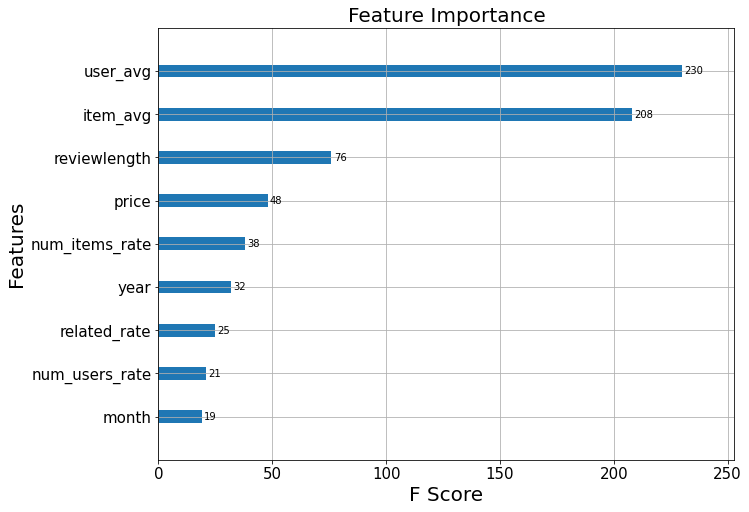

In [77]:
x_train = train_surprice.drop(["reviewerID", "asin", "overall"], axis = 1)

x_test = test_surprice.drop(["reviewerID", "asin", "overall"], axis = 1)

y_train = train_surprice["overall"]

y_test = test_surprice["overall"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGBoost_13")

model_train_evaluation["XGBoost_13"] = train_result
model_test_evaluation["XGBoost_13"] = test_result

### Surprise BaselineOnly Model

In [78]:
bsl_options = {"method":"sgd", "learning_rate":0.01, "n_epochs":25}

algo = BaselineOnly(bsl_options=bsl_options)
#You can check the docs of above used functions at:https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#baseline-estimates-configuration
#at section "Baselines estimates configuration".

train_result, test_result = run_surprise(algo, trainset, testset, "BaselineOnly")

model_train_evaluation["BaselineOnly"] = train_result
model_test_evaluation["BaselineOnly"] = test_result

Estimating biases using sgd...
--------------------------------------------------
TRAIN DATA
RMSE = 0.8007449022620281
MAE = 0.5559096304270534
--------------------------------------------------
TEST DATA
RMSE = 0.9388698292313251
MAE = 0.6506311856729223
--------------------------------------------------
Time Taken = 0:00:01.458901


### XGBoost 13 Features + Suprise BaselineOnly Model

In [79]:
train_surprice['BaselineOnly'] = model_train_evaluation['BaselineOnly']['Prediction']

In [80]:
train_surprice.head()

,reviewerID,asin,overall,price,year,month,reviewlength,user_avg,item_avg,num_users_rate,num_items_rate,related_rate,BaselineOnly
5510,A3RX2SPLAXUFZH,B00004UE6N,5.0,11.41,2013,1,32,4.700000,4.600000,20,10,4.497238,5.000000
10327,A1KAOMGBS8G3PU,B00006IUTQ,5.0,6.65,2013,1,27,5.000000,4.315789,19,6,4.395469,4.476471
57188,A3S0Y5GVW1CYRW,B003UDHOD0,4.0,12.99,2013,2,112,4.833333,4.060000,50,18,4.488038,4.396793
37346,A3EPHBMU07LZ50,B000SAU3OU,2.0,29.87,2014,6,151,4.200000,3.750000,12,70,3.750000,5.000000
64947,A194K60CWZ371J,B005LCT5I0,5.0,9.99,2012,9,323,4.904762,4.271930,114,21,4.388998,5.000000


In [81]:
test_surprice['BaselineOnly'] = model_test_evaluation['BaselineOnly']['Prediction']

[06:23:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
--------------------------------------------------
TRAIN DATA
RMSE = 0.7791140433419513
MAE = 0.5218682177535976
--------------------------------------------------
TEST DATA
RMSE = 0.5774546825241998
MAE = 0.34674890570698425
--------------------------------------------------
Time Taken = 0:00:03.200359


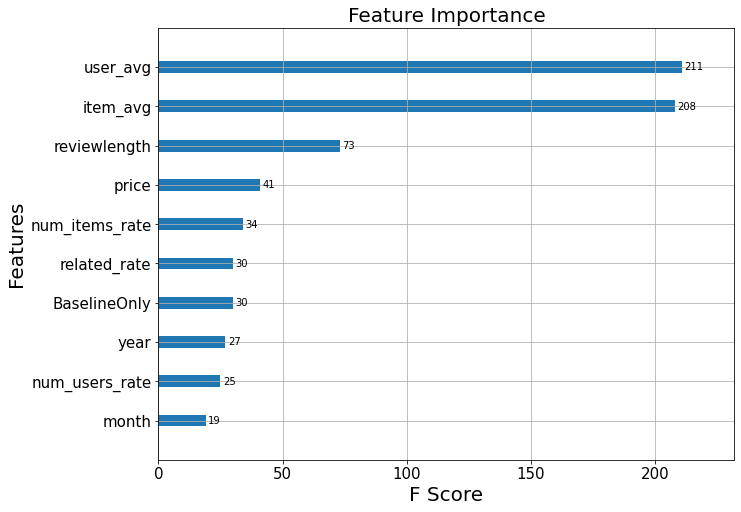

In [82]:
x_train = train_surprice.dropna().drop(["reviewerID", "asin", "overall"], axis = 1)

x_test = test_surprice.dropna().drop(["reviewerID", "asin", "overall"], axis = 1)

y_train = train_surprice.dropna().overall

y_test = test_surprice.dropna().overall

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_BSL")

model_train_evaluation["XGB_BSL"] = train_result
model_test_evaluation["XGB_BSL"] = test_result

### Surprise KNN-Baseline with User-User.

In [83]:
param_grid  = {'sim_options':{'name': ["pearson_baseline"], "user_based": [True], "min_support": [2], "shrinkage": [60, 80, 80, 140]}, 'k': [5, 20, 40, 80]}

gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

In [84]:
sim_options = {'name':'pearson_baseline', 'user_based':True, 'min_support':2, 'shrinkage':gs.best_params['rmse']['sim_options']['shrinkage']}

bsl_options = {'method': 'sgd'} 

algo = KNNBaseline(k = gs.best_params['rmse']['k'], sim_options = sim_options, bsl_options=bsl_options)

train_result, test_result = run_surprise(algo, trainset, testset, "KNNBaseline_User")

model_train_evaluation["KNNBaseline_User"] = train_result
model_test_evaluation["KNNBaseline_User"] = test_result

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
--------------------------------------------------
TRAIN DATA
RMSE = 0.015100086233830846
MAE = 0.0049855987315489455
--------------------------------------------------
TEST DATA
RMSE = 0.9550414148064635
MAE = 0.671945803754505
--------------------------------------------------
Time Taken = 0:00:10.101809


### Surprise KNN-Baseline with Item-Item

In [85]:
param_grid  = {'sim_options':{'name': ["pearson_baseline"], "user_based": [False], "min_support": [2], "shrinkage": [60, 80, 80, 140]}, 'k': [5, 20, 40, 80]}

gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

In [86]:
sim_options = {'name':'pearson_baseline', 'user_based':False, 'min_support':2, 'shrinkage':gs.best_params['rmse']['sim_options']['shrinkage']}

bsl_options = {'method': 'sgd'} 

algo = KNNBaseline(k = gs.best_params['rmse']['k'], sim_options = sim_options, bsl_options=bsl_options)

train_result, test_result = run_surprise(algo, trainset, testset, "KNNBaseline_Item")

model_train_evaluation["KNNBaseline_Item"] = train_result
model_test_evaluation["KNNBaseline_Item"] = test_result

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
--------------------------------------------------
TRAIN DATA
RMSE = 0.014169938970007968
MAE = 0.004502304107563923
--------------------------------------------------
TEST DATA
RMSE = 0.9754816320977595
MAE = 0.6752642032841679
--------------------------------------------------
Time Taken = 0:00:03.206899


### XGBoost 13 Features + Surprise BaselineOnly + Surprice KNN Baseline

In [87]:
train_surprice["KNNBaseline_User"] = model_train_evaluation["KNNBaseline_User"]["Prediction"]
train_surprice["KNNBaseline_Item"] = model_train_evaluation["KNNBaseline_Item"]["Prediction"]

test_surprice["KNNBaseline_User"] = model_test_evaluation["KNNBaseline_User"]["Prediction"]
test_surprice["KNNBaseline_Item"] = model_test_evaluation["KNNBaseline_Item"]["Prediction"]

In [88]:
train_surprice.head()

,reviewerID,asin,overall,price,year,month,reviewlength,user_avg,item_avg,num_users_rate,num_items_rate,related_rate,BaselineOnly,KNNBaseline_User,KNNBaseline_Item
5510,A3RX2SPLAXUFZH,B00004UE6N,5.0,11.41,2013,1,32,4.700000,4.600000,20,10,4.497238,5.000000,5.000000,4.998407
10327,A1KAOMGBS8G3PU,B00006IUTQ,5.0,6.65,2013,1,27,5.000000,4.315789,19,6,4.395469,4.476471,4.999580,4.993815
57188,A3S0Y5GVW1CYRW,B003UDHOD0,4.0,12.99,2013,2,112,4.833333,4.060000,50,18,4.488038,4.396793,4.997204,4.995926
37346,A3EPHBMU07LZ50,B000SAU3OU,2.0,29.87,2014,6,151,4.200000,3.750000,12,70,3.750000,5.000000,5.000000,5.000000
64947,A194K60CWZ371J,B005LCT5I0,5.0,9.99,2012,9,323,4.904762,4.271930,114,21,4.388998,5.000000,4.994020,5.000000


In [89]:
test_surprice.head()

,reviewerID,asin,overall,price,year,month,reviewlength,user_avg,item_avg,num_users_rate,num_items_rate,related_rate,BaselineOnly,KNNBaseline_User,KNNBaseline_Item
20891,A2LPKG76VV1UW0,B0002JENOS,5.0,9.95,2011,9,68,5.000000,5.000000,3,2,4.564431,4.055442,4.274098,4.274098
17104,A399D9P2ZK876W,B0000E2GT5,5.0,9.95,2008,12,19,5.000000,4.666667,9,2,4.561644,4.471161,4.335524,4.335524
35831,AKECLRCG15H8P,B000PBZHOS,5.0,1.95,2014,3,51,5.000000,4.800000,5,1,4.569038,4.485111,4.419999,4.594111
16608,A28HVL8ZZJEH21,B0000DE2SS,1.0,16.82,2013,11,46,2.666667,3.200000,5,3,4.426686,4.647066,3.208810,4.552770
67448,A2FFWYG9YYZFA5,B006P1VAW0,4.0,249.50,2012,8,77,2.500000,4.666667,3,2,4.333333,4.040120,4.155133,1.349668


[06:28:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
--------------------------------------------------
TRAIN DATA
RMSE = 0.7790131548358277
MAE = 0.5210407527178265
--------------------------------------------------
TEST DATA
RMSE = 0.5765184660837651
MAE = 0.34477916875548953
--------------------------------------------------
Time Taken = 0:00:03.600912


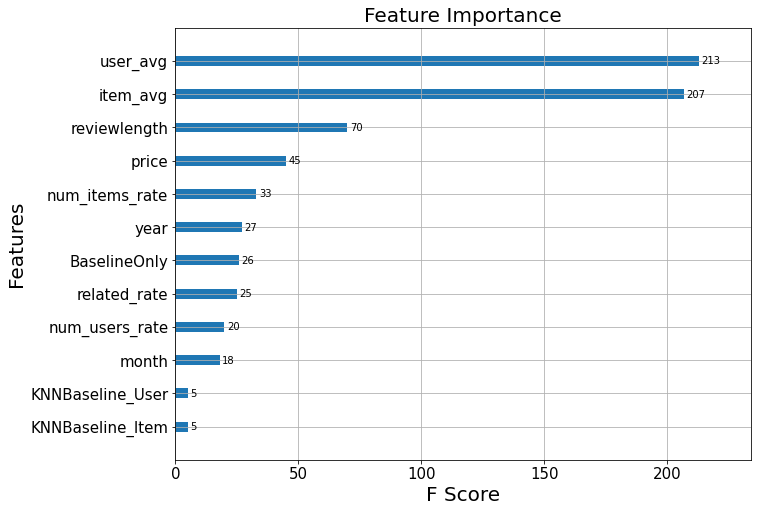

In [90]:
x_train = train_surprice.dropna().drop(["reviewerID", "asin", "overall"], axis = 1)

x_test = test_surprice.dropna().drop(["reviewerID", "asin", "overall"], axis = 1)

y_train = train_surprice.dropna().overall

y_test = test_surprice.dropna().overall

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_BSL_KNN")

model_train_evaluation["XGB_BSL_KNN"] = train_result
model_test_evaluation["XGB_BSL_KNN"] = test_result

#### Matrix Factorization SVD

In [91]:
param_grid  = {'n_factors': [5,7,10,15,20,25,35,50,70,90]}   
#n_factors is the equivalent to dimension 'd' when matrix 'A' is broken into 'b' and 'c'. 
#So, matrix 'A' will be of dimension n*m. So, matrices 'b' and 'c' will be of dimension n*d and m*d.

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9502156740800705
{'n_factors': 7}


In [92]:
algo = SVD(n_factors = gs.best_params['rmse']['n_factors'], biased=True, verbose=True)

train_result, test_result = run_surprise(algo, trainset, testset, "SVD")

model_train_evaluation["SVD"] = train_result
model_test_evaluation["SVD"] = test_result

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
--------------------------------------------------
TRAIN DATA
RMSE = 0.8280856070539178
MAE = 0.5900478131702849
--------------------------------------------------
TEST DATA
RMSE = 0.9316615411167003
MAE = 0.6638819339320843
--------------------------------------------------
Time Taken = 0:00:02.384560


#### Matrix Factorization SVDpp with implicit feedback

In [93]:
param_grid = {'n_factors': [10, 30, 50, 80, 100], 'lr_all': [0.002, 0.006, 0.018, 0.054, 0.10]}

gs = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9517057577771868
{'n_factors': 10, 'lr_all': 0.006}


In [94]:
algo = SVDpp(n_factors = gs.best_params['rmse']['n_factors'], lr_all = gs.best_params['rmse']["lr_all"], verbose=True)

train_result, test_result = run_surprise(algo, trainset, testset, "SVDpp")

model_train_evaluation["SVDpp"] = train_result
model_test_evaluation["SVDpp"] = test_result

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
--------------------------------------------------
TRAIN DATA
RMSE = 0.7867881831679915
MAE = 0.5578316695906979
--------------------------------------------------
TEST DATA
RMSE = 0.9328165888727178
MAE = 0.6601987724144586
--------------------------------------------------
Time Taken = 0:00:15.143467


### XGBoost 13 Features + Surprice BaselineOnly + Surprise KNN Baseline + SVD + SVDpp

In [95]:
train_surprice["SVD"] = model_train_evaluation["SVD"]["Prediction"]
train_surprice["SVDpp"] = model_train_evaluation["SVDpp"]["Prediction"]

test_surprice["SVD"] = model_test_evaluation["SVD"]["Prediction"]
test_surprice["SVDpp"] = model_test_evaluation["SVDpp"]["Prediction"]

In [96]:
train_surprice.head()

,reviewerID,asin,overall,price,year,month,reviewlength,user_avg,item_avg,num_users_rate,num_items_rate,related_rate,BaselineOnly,KNNBaseline_User,KNNBaseline_Item,SVD,SVDpp
5510,A3RX2SPLAXUFZH,B00004UE6N,5.0,11.41,2013,1,32,4.700000,4.600000,20,10,4.497238,5.000000,5.000000,4.998407,4.905017,4.766254
10327,A1KAOMGBS8G3PU,B00006IUTQ,5.0,6.65,2013,1,27,5.000000,4.315789,19,6,4.395469,4.476471,4.999580,4.993815,4.322577,4.596653
57188,A3S0Y5GVW1CYRW,B003UDHOD0,4.0,12.99,2013,2,112,4.833333,4.060000,50,18,4.488038,4.396793,4.997204,4.995926,4.274613,4.270980
37346,A3EPHBMU07LZ50,B000SAU3OU,2.0,29.87,2014,6,151,4.200000,3.750000,12,70,3.750000,5.000000,5.000000,5.000000,4.914353,4.964367
64947,A194K60CWZ371J,B005LCT5I0,5.0,9.99,2012,9,323,4.904762,4.271930,114,21,4.388998,5.000000,4.994020,5.000000,4.928370,4.937880


[06:46:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
--------------------------------------------------
TRAIN DATA
RMSE = 0.7790118734020521
MAE = 0.5212017251210974
--------------------------------------------------
TEST DATA
RMSE = 0.576900544812674
MAE = 0.3456237320207025
--------------------------------------------------
Time Taken = 0:00:04.284612


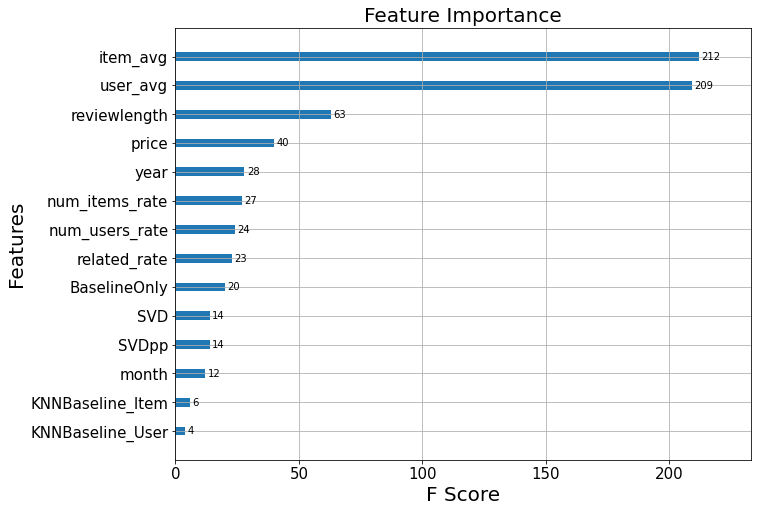

In [97]:
x_train = train_surprice.dropna().drop(["reviewerID", "asin", "overall"], axis = 1)

x_test = test_surprice.dropna().drop(["reviewerID", "asin", "overall"], axis = 1)

y_train = train_surprice.dropna().overall

y_test = test_surprice.dropna().overall

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_BSL_KNN_MF")

model_train_evaluation["XGB_BSL_KNN_MF"] = train_result
model_test_evaluation["XGB_BSL_KNN_MF"] = test_result

In [98]:
error_table.style.highlight_min(axis=0)

,Model,Train RMSE,Train MAE,Test RMSE,Test MAE
0,XGBoost_13,0.779322,0.520739,0.576727,0.343322
1,BaselineOnly,0.800745,0.555910,0.938870,0.650631
2,XGB_BSL,0.779114,0.521868,0.577455,0.346749
3,KNNBaseline_User,0.015100,0.004986,0.955041,0.671946
4,KNNBaseline_Item,0.014170,0.004502,0.975482,0.675264
5,XGB_BSL_KNN,0.779013,0.521041,0.576518,0.344779
6,SVD,0.828086,0.590048,0.931662,0.663882
7,SVDpp,0.786788,0.557832,0.932817,0.660199
8,XGB_BSL_KNN_MF,0.779012,0.521202,0.576901,0.345624


/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


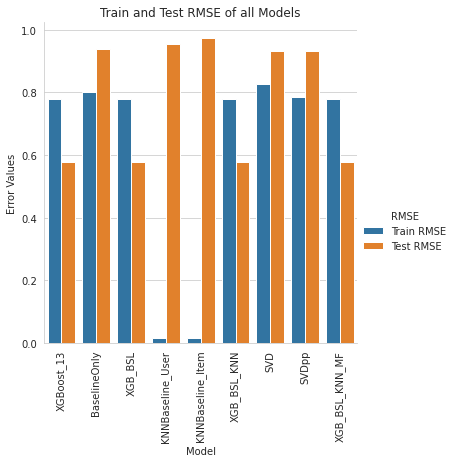

In [99]:
sns.set_style("whitegrid")
error_table_melt = error_table.drop(['Train MAE', 'Test MAE'], axis = 1).melt('Model', var_name='RMSE', value_name='vals')
sns.factorplot(x='Model', y='vals', hue='RMSE', data = error_table_melt, kind='bar')
plt.xticks(rotation=90)
plt.title("Train and Test RMSE of all Models")
plt.ylabel("Error Values")
plt.show()

The best model so far is the "XGBboost + BaselineOnly + Surprise KNN Baseline" model. The test RMSE is 0.5765.

In [109]:
new_test = pd.DataFrame(y_test)
new_test['predicted'] = pd.DataFrame(model_test_evaluation["XGB_BSL_KNN"]["Prediction"]).values

In [110]:
new_test

,overall,predicted
20891,5.0,5.015704
17104,5.0,5.043291
35831,5.0,4.994487
16608,1.0,1.804514
67448,4.0,3.248988
...,...,...
25466,3.0,2.395674
49908,4.0,4.633029
52027,5.0,5.021597
37823,5.0,4.946294
